## Generate Docstring for Python Functions

Dataset Source: https://huggingface.co/datasets/kejian/codesearchnet-python-raw

#### Install Necessary Libraries

In [1]:
%pip install transformers datasets evaluate torch tqdm rouge_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 64.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 45.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 KB 11.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 92.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 50.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 

#### Import Necessary Libraries

In [2]:
import os, sys

import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import transformers
from transformers import AutoTokenizer, Seq2SeqTrainer, Seq2SeqTrainingArguments
from transformers import set_seed, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq

import torch
from torch.utils.data import DataLoader

import datasets
from datasets import load_dataset, DatasetDict, Dataset
import evaluate

!git lfs install

Error: Failed to call git rev-parse --git-dir: exit status 128 
Git LFS initialized.


#### HuggingFace Access

In [3]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) Y
Token is valid.
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in case you want to set the 'store' credential helper as d

#### Mount Google Drive to Notebook

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Display Library Versions

In [5]:
n = 20

print("Library/Language:".rjust(n), "Version")
print("Python:".rjust(n), sys.version[0:6])
print("NumPy:".rjust(n), np.__version__)
print("Pandas:".rjust(n), pd.__version__)
print("Torch:".rjust(n), torch.__version__)
print("Datasets:".rjust(n), datasets.__version__)
print("Transformers:".rjust(n), transformers.__version__)
print("Evaluate:".rjust(n), evaluate.__version__)

   Library/Language: Version
             Python: 3.9.16
              NumPy: 1.22.4
             Pandas: 1.4.4
              Torch: 1.13.1+cu116
           Datasets: 2.10.1
       Transformers: 4.27.3
           Evaluate: 0.4.0


#### Ingest Dataset

In [6]:
dataset = load_dataset("kejian/codesearchnet-python-raw")

dataset

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/200000 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/kejian___parquet/kejian--codesearchnet-python-raw-60e8da1922a22e3e/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['repo', 'path', 'url', 'code', 'code_tokens', 'docstring', 'docstring_tokens', 'language', 'partition'],
        num_rows: 200000
    })
})

#### Convert to Pandas DataFrame

In [7]:
dataset.set_format("pandas")
df = dataset['train'][:]

df

,repo,path,url,code,code_tokens,docstring,docstring_tokens,language,partition
0,googleapis/google-cloud-python,bigquery/google/cloud/bigquery/client.py,https://github.com/googleapis/google-cloud-pyt...,"def dataset(self, dataset_id, project=None):\n...","[def, dataset, (, self, ,, dataset_id, ,, proj...",Construct a reference to a dataset.\n\n ...,"[Construct, a, reference, to, a, dataset, .]",python,train
1,honzamach/pydgets,pydgets/widgets.py,https://github.com/honzamach/pydgets/blob/5ca4...,"def _render_content(self, content, **settings)...","[def, _render_content, (, self, ,, content, ,,...","Perform widget rendering, but do not print any...","[Perform, widget, rendering, but, do, not, pri...",python,train
2,alvations/pywsd,pywsd/utils.py,https://github.com/alvations/pywsd/blob/4c1239...,"def remove_tags(text: str) -> str:\n """""" Re...","[def, remove_tags, (, text, :, str, ), ->, str...",Removes <tags> in angled brackets from text.,"[Removes, <tags, >, in, angled, brackets, from...",python,train
3,frictionlessdata/tableschema-pandas-py,tableschema_pandas/mapper.py,https://github.com/frictionlessdata/tableschem...,"def restore_row(self, row, schema, pk):\n ...","[def, restore_row, (, self, ,, row, ,, schema,...",Restore row from Pandas,"[Restore, row, from, Pandas]",python,train
4,klen/muffin-debugtoolbar,muffin_debugtoolbar/tbtools/tbtools.py,https://github.com/klen/muffin-debugtoolbar/bl...,"def render_full(self, request, lodgeit_url=Non...","[def, render_full, (, self, ,, request, ,, lod...",Render the Full HTML page with the traceback i...,"[Render, the, Full, HTML, page, with, the, tra...",python,train
...,...,...,...,...,...,...,...,...,...
199995,pypa/pipenv,pipenv/vendor/cerberus/validator.py,https://github.com/pypa/pipenv/blob/cae8d76c21...,"def _drop_nodes_from_errorpaths(self, _errors,...","[def, _drop_nodes_from_errorpaths, (, self, ,,...","Removes nodes by index from an errorpath, rela...","[Removes, nodes, by, index, from, an, errorpat...",python,train
199996,mkouhei/bootstrap-py,bootstrap_py/commands.py,https://github.com/mkouhei/bootstrap-py/blob/9...,"def valid_url(url):\n """"""Validate url.\n\n ...","[def, valid_url, (, url, ), :, regex, =, re, ....",Validate url.\n\n :rtype: str\n :return:...,"[Validate, url, .]",python,train
199997,raamana/mrivis,mrivis/base.py,https://github.com/raamana/mrivis/blob/199ad09...,"def _apply_mask(self, roi_mask):\n """"""R...","[def, _apply_mask, (, self, ,, roi_mask, ), :,...",Removes voxels outside the given mask or ROI set.,"[Removes, voxels, outside, the, given, mask, o...",python,train
199998,wummel/linkchecker,linkcheck/director/console.py,https://github.com/wummel/linkchecker/blob/c2c...,"def print_app_info (out=stderr):\n """"""Print...","[def, print_app_info, (, out, =, stderr, ), :,...",Print system and application info (output defa...,"[Print, system, and, application, info, (, out...",python,train


#### Drop unnecessary features

In [8]:
df = df.drop(columns=["repo", "path", "url", "code_tokens", "docstring_tokens", "language", "partition"])

#### Remove Docstring From 'Code' Feature

In [9]:
def remove_docstring(row):
    code_split = row.split('"""')
    return code_split[0] + code_split[-1]

df['code'] = df['code'].apply(remove_docstring)

df

,code,docstring
0,"def dataset(self, dataset_id, project=None):\n...",Construct a reference to a dataset.\n\n ...
1,"def _render_content(self, content, **settings)...","Perform widget rendering, but do not print any..."
2,def remove_tags(text: str) -> str:\n \n\n ...,Removes <tags> in angled brackets from text.
3,"def restore_row(self, row, schema, pk):\n ...",Restore row from Pandas
4,"def render_full(self, request, lodgeit_url=Non...",Render the Full HTML page with the traceback i...
...,...,...
199995,"def _drop_nodes_from_errorpaths(self, _errors,...","Removes nodes by index from an errorpath, rela..."
199996,def valid_url(url):\n \n regex = re.comp...,Validate url.\n\n :rtype: str\n :return:...
199997,"def _apply_mask(self, roi_mask):\n \n\n...",Removes voxels outside the given mask or ROI set.
199998,def print_app_info (out=stderr):\n \n pr...,Print system and application info (output defa...


#### Visualize: Word Length of Code (Input)

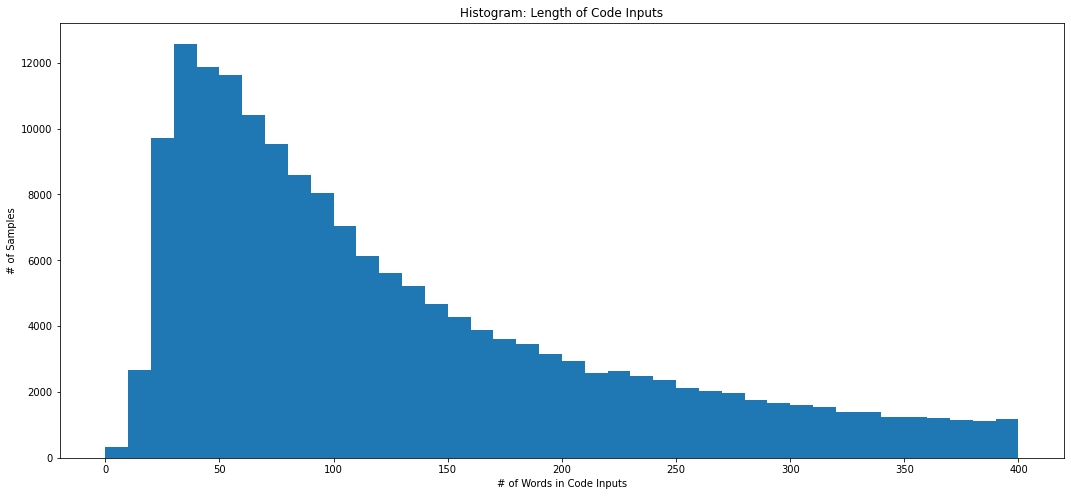

The maximum length of Code Inputs (in words) is 67783 words.


In [10]:
df['code_length'] = df['code'].str.split(" ").str.len()

n_bin=400
df.hist('code_length', grid=False, figsize=(18,8), range=(0,n_bin), bins=int(n_bin/10))
plt.title('Histogram: Length of Code Inputs')
plt.xlabel('# of Words in Code Inputs')
plt.ylabel('# of Samples')
plt.show()

print(f"The maximum length of Code Inputs (in words) is {max(df['code_length'])} words.")

#### Visualize: Word Length of Docstrings (Output)

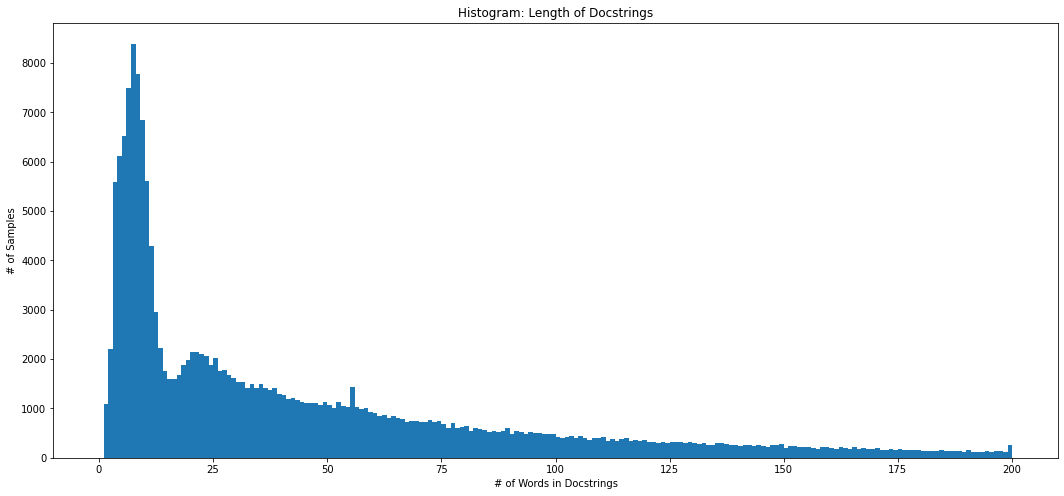

The maximum length of Docstrings (in words) is 12846 words.


In [11]:
df['docstring_length'] = df['docstring'].str.split(" ").str.len()

n_bin=200
df.hist('docstring_length', grid=False, figsize=(18,8), range=(0,n_bin), bins=n_bin)
plt.title('Histogram: Length of Docstrings')
plt.xlabel('# of Words in Docstrings')
plt.ylabel('# of Samples')
plt.show()

print(f"The maximum length of Docstrings (in words) is {max(df['docstring_length'])} words.")

#### Trim Overly Lengthy Code Samples & Docstrings

In [12]:
df = df[df['code_length'] < 400]
df = df[df['docstring_length'] < 200]

#### Convert DataFrame Back to Dataset

In [13]:
dataset = Dataset.from_pandas(df)

#### Split Code into Training/Testing/Evaluation Datasets

In [14]:
train_testvalid = dataset.train_test_split(train_size=0.80)
test_eval = train_testvalid['test'].train_test_split(train_size=0.50)

ds = DatasetDict({
    'train': train_testvalid['train'], 
    'test': test_eval['test'], 
    'eval': test_eval['train']})

print('Training data shape:', ds['train'].shape)
print('Testing data shape:', ds['test'].shape)
print('Validation data shape:', ds['eval'].shape)

Training data shape: (126607, 5)
Testing data shape: (15826, 5)
Validation data shape: (15826, 5)


#### Print an Example

In [15]:
example = ds['train'][0]

print("Code:", example["code"])
print("\nDocstring:", example["docstring"])

Code: def unsetNsProp(self, node, name):
        
        if node is None: node__o = None
        else: node__o = node._o
        ret = libxml2mod.xmlUnsetNsProp(node__o, self._o, name)
        return ret

Docstring: Remove an attribute carried by a node.


#### Basic Values/Constants

In [27]:
MODEL_CKPT = "Salesforce/codet5-small"
MODEL_NAME = MODEL_CKPT.split("/")[-1] + "-Generate_Docstrings_for_Python"

T5_PREFIX = "Summarize python: "
NUM_OF_EPOCHS = 1

MAX_INPUT_LENGTH = int(400 * 1.25 + 3)
MAX_TARGET_LENGTH = int(200 * 1.25)

REPORTS_TO = "tensorboard"
STRATEGY = "epoch"

DEVICE = torch.device("cuda")
set_seed = 42

LR = 2e-5
BATCH_SIZE = 16

#### Instantiate Tokenizer

In [28]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_CKPT)

#### Define Function for Preprocessing Dataset

In [29]:
def preprocess_samples(samples):
    codes = samples['code']
    docstrings = samples['docstring']
    
    inputs = [T5_PREFIX + code for code in codes]
    model_inputs = tokenizer(inputs, 
                             max_length=MAX_INPUT_LENGTH, 
                             padding="max_length", 
                             truncation=True)
    
    labels = tokenizer(docstrings, 
                       max_length=MAX_TARGET_LENGTH, 
                       padding="max_length", 
                       truncation=True
                       ).input_ids
    
    labels_with_ignore_index = []
    for label_ex in labels:
        label_ex = [label if label != 0 else -100 for label in label_ex]
        labels_with_ignore_index.append(label_ex)
    
    model_inputs["labels"] = labels_with_ignore_index
    
    return model_inputs

#### Apply Preprocessing Function to Dataset

In [30]:
encoded_ds = ds.map(preprocess_samples, 
                         batched=True)

Map:   0%|          | 0/126607 [00:00<?, ? examples/s]

Map:   0%|          | 0/15826 [00:00<?, ? examples/s]

Map:   0%|          | 0/15826 [00:00<?, ? examples/s]

#### Check That Preprocessing Worked as Expected

In [31]:
encoded_ds

DatasetDict({
    train: Dataset({
        features: ['code', 'docstring', 'code_length', 'docstring_length', '__index_level_0__', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 126607
    })
    test: Dataset({
        features: ['code', 'docstring', 'code_length', 'docstring_length', '__index_level_0__', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 15826
    })
    eval: Dataset({
        features: ['code', 'docstring', 'code_length', 'docstring_length', '__index_level_0__', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 15826
    })
})

#### Define Data Collator

In [32]:
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=MODEL_CKPT)

#### Define Function to Compute Metrics

In [33]:
rouge_metric = evaluate.load("rouge")

def compute_metrics(preds):
    predictions, labels = preds
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    result = rouge_metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)

    return {k: round(v, 4) for k, v in result.items()}

#### Define Model

In [34]:
model = (AutoModelForSeq2SeqLM.from_pretrained(MODEL_CKPT)).to(DEVICE)

#### Define TrainingArguments

In [35]:
args = Seq2SeqTrainingArguments(output_dir=MODEL_NAME,
                         num_train_epochs=NUM_OF_EPOCHS,
                         report_to=REPORTS_TO,
                         learning_rate=LR,
                         logging_strategy=STRATEGY,
                         evaluation_strategy=STRATEGY,
                         per_device_train_batch_size=BATCH_SIZE,
                         per_device_eval_batch_size=BATCH_SIZE,
                         save_strategy=STRATEGY,
                         predict_with_generate=True,
                         logging_first_step=True,
                         hub_private_repo=True,
                         push_to_hub=True
                         )

#### Define Trainer

In [36]:
trainer = Seq2SeqTrainer(model=model,
                  args=args,
                  data_collator=data_collator,
                  compute_metrics=compute_metrics,
                  tokenizer=tokenizer,
                  train_dataset=encoded_ds['train'],
                  eval_dataset=encoded_ds['eval'])

/content/codet5-small-Generate_Docstrings_for_Python is already a clone of https://huggingface.co/DunnBC22/codet5-small-Generate_Docstrings_for_Python. Make sure you pull the latest changes with `repo.git_pull()`.


#### Train Model

In [37]:
training_results = trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
1,2.744700,2.411625,0.338100,0.154100,0.304500,0.321400,15.808800


#### Evaluate Model

In [38]:
score = trainer.evaluate()

#### Push Model to Hub (My Profile!!!)

In [39]:
trainer.push_to_hub()

Upload file runs/Mar24_17-20-53_4a1c201514e1/events.out.tfevents.1679678459.4a1c201514e1.127.2: 100%|#########…

Upload file runs/Mar24_17-20-53_4a1c201514e1/events.out.tfevents.1679686429.4a1c201514e1.127.4: 100%|#########…

To https://huggingface.co/DunnBC22/codet5-small-Generate_Docstrings_for_Python
   4e957c9..6a643b7  main -> main

   4e957c9..6a643b7  main -> main

To https://huggingface.co/DunnBC22/codet5-small-Generate_Docstrings_for_Python
   6a643b7..e4813b2  main -> main

   6a643b7..e4813b2  main -> main



'https://huggingface.co/DunnBC22/codet5-small-Generate_Docstrings_for_Python/commit/6a643b762b0bf6d3920d181b13e8947263febd58'

### Notes & Other Takeaways From This Project
****
- While the metrics are not as good as I would like, I did not have the chance to train this is long as I wanted to. Originally, I had this project set to run three epochs (and even considered increasing it to four epochs). Once I saw that the time limits in Google Colab would not allow me to train that long, I realized that I could only train it for a single epoch. I am sure the results would improve if I could run this model for 3, if not 4, epochs.

****

### Citations

- Model Checkpoint
> @misc{wang2021codet5, title={CodeT5: Identifier-aware Unified Pre-trained Encoder-Decoder Models for Code Understanding and Generation}, author={Yue Wang and Weishi Wang and Shafiq Joty and Steven C. H. Hoi}, year={2021}, eprint={2109.00859}, archivePrefix={arXiv}, primaryClass={cs.CL}
}

- Metric (Rouge)
> @inproceedings{lin-2004-rouge,
    title = "{ROUGE}: A Package for Automatic Evaluation of Summaries",
    author = "Lin, Chin-Yew",
    booktitle = "Text Summarization Branches Out",
    month = jul,
    year = "2004",
    address = "Barcelona, Spain",
    publisher = "Association for Computational Linguistics",
    url = "https://www.aclweb.org/anthology/W04-1013",
    pages = "74--81",
}